<a href="https://colab.research.google.com/github/sumu97/Data-Science-Cheat-Code/blob/main/%EB%85%B8%EC%9B%90%EA%B5%AC%20%EC%95%84%ED%8C%8C%ED%8A%B8%20%EC%A4%91%EC%9C%84%EA%B0%80%EA%B2%A9%20%EC%98%88%EC%B8%A1%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 설치 : 이 셀을 실행한 후, 완료되면 [런타임] >> [런타임 다시 시작]을 합니다.
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [2]:
# 폰트설정
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)

In [3]:
# EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def column_cleaning(col):
  temp_list = []
  for i in col:
    temp = i[0:4] + '-' + i[6:8]
    temp_list.append(temp)

  return temp_list

def eda(data,gu):
  edf = pd.read_excel(io=data)
  edf = edf.T

  date = edf[9].values.tolist() # 날짜 추출 -> 리스트
  del date[0:4]
  date = column_cleaning(date)
  

  edf = edf.drop(edf.index[0:3]) # 가격 추출 -> 리스트
  edf = edf.rename(columns=edf.iloc[0])
  value = edf[gu].values.tolist() # 입력 : 지역
  del value[0] # ~구 써있는 행 삭제

  df = pd.DataFrame({'date':date, 'price':value}) # 데이터프레임 생성
  df['date'] = pd.to_datetime(df['date']) # 날짜 열 Feature 변경 : datetime
  df.set_index('date', inplace = True) # 날짜 열을 인덱스로

  return df

df1 = eda('중위매매가격_아파트.xlsx', '노원구')
df2 = eda('매매가_대비_중위가격.xlsx', '노원구')

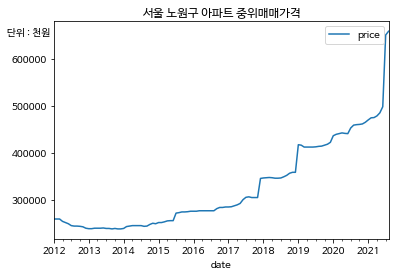

In [4]:
# 결과값 시각화
df1.plot()
plt.title('서울 노원구 아파트 중위매매가격')
plt.text(488,650000,'단위 : 천원')
plt.show()

In [5]:
# 테스트용 데이터 생성 (마지막 월 -5)
test_df = df1.drop(df1.index[-5:-1])
test_df = test_df.drop(test_df.index[-1])
test_df

,price
date,
2012-01-01,260000
2012-02-01,260000
2012-03-01,260000
2012-04-01,255000
2012-05-01,252500
...,...
2020-11-01,461500
2020-12-01,465000
2021-01-01,470000


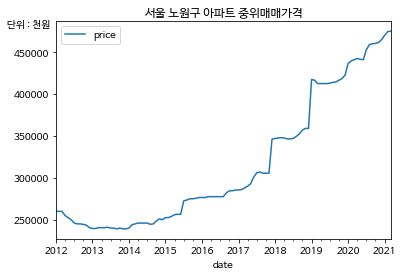

In [6]:
# 시각화
test_df.plot()
plt.title('서울 노원구 아파트 중위매매가격')
plt.text(488,480000,'단위 : 천원')
plt.show()

# ARIMA
  - 전통적인 시계열 예측 방법
    - AR(Autoregression) 모델 : 자신의 과거를 정보로 사용하는 개념
    - MA(Moving Average) 모델 : 이번 항에서의 오차를 이용, 현재 항의 상태를 추론
    - 두가지가 합쳐진 것을 ARMA 모델이라고 함
    - ARIMA(Autoregressice Integrated Moving Average)모델은 ARMA 모델에 추세 변동의 경향성까지 반영한 방법
  - 파이썬에서의 활용
    - statsmodel 모델로 분석 수행 가능함

In [114]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

model = ARIMA(test_df.price.values, order = (3,2,1))
# AR = 3, 차분 = 1, MA = 2 파라미터로 ARIMA 모델을 학습한다.

  - AR
    - AR 모델이 몇번째 과거까지를 바라보는지에 대한 파라미터
  - 차분
    - 차분(Defference) 시계열의 수준에서 나타나는 변화를 제거, 평균변화 일정하게 만드는데 도움이 될 수 있음
  - MA
    - MA가 몇번째 과거까지를 바라보는지에 대한 파라미터

In [115]:
# ARIMA 모델 학습
model_fit = model.fit(trend = 'c', full_output = True, disp = True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  109
Model:                 ARIMA(3, 2, 1)   Log Likelihood               -1121.716
Method:                       css-mle   S.D. of innovations           6963.441
Date:                Sun, 03 Oct 2021   AIC                           2255.433
Time:                        09:38:45   BIC                           2271.581
Sample:                             2   HQIC                          2261.982
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.7681     17.146      3.078      0.003      19.162      86.374
ar.L1.D2.y    -0.0642      0.096     -0.670      0.505      -0.252       0.124
ar.L2.D2.y    -0.1082      0.095     -1.141      0.2

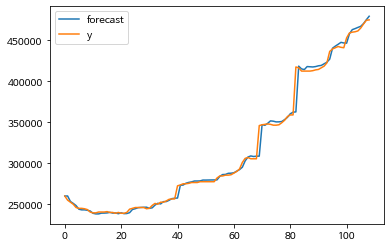

In [116]:
# 학습 데이터에 대한 예측 결과
fig = model_fit.plot_predict()

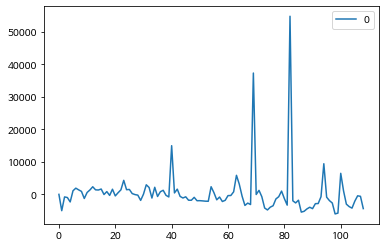

In [117]:
# 실제값과 예측값 사이의 오차 변동
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

In [159]:
# 모델 평가
forecast_data = model_fit.forecast(steps=5) 

test_df1 = df1[111:]
test_df1

,price
date,
2021-04-01,478500
2021-05-01,485000
2021-06-01,498000
2021-07-01,650000
2021-08-01,658000


In [120]:
# 마지막 5월의 예측 데이터
pred_y = forecast_data[0].tolist()

# 실제 5월의 데이터
test_y = test_df1.price.values

# 마지막 5월의 예측 데이터 최소값
pred_y_lower = []

# 마지막 5월의 예측 데이터 최대값
pred_y_upper = []

In [123]:
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

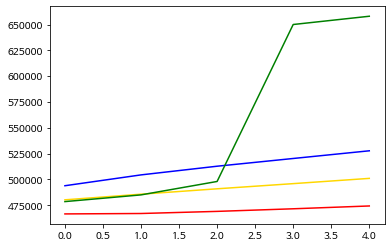

In [124]:
# 모델이 예측한 가격 그래프
plt.plot(pred_y, color = 'gold')

# 모델이 예측한 최저 가격 그래프
plt.plot(pred_y_lower, color = 'red')

# 모델이 예측한 최고 가격 그래프
plt.plot(pred_y_upper, color = 'blue')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

오차 변동은 전체의 80% 이상에서 5백만원 이내의 오차를 보였으나 \
2015년, 2017년, 2019년에는 예측이 크게 어긋남.

최근의 큰 변동성도 예측하지 못함.

아래는 2021년 9월부터 12개월의 예측이다.


In [142]:
# AR = 5, 차분 = 2, MA = 1 파라미터로 ARIMA 모델을 학습한다.
model = ARIMA(df1.price.values, order = (5,2,1))
model_fit = model.fit(trend = 'c', full_output = True, disp = True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  114
Model:                 ARIMA(5, 2, 1)   Log Likelihood               -1261.276
Method:                       css-mle   S.D. of innovations          15084.841
Date:                Sun, 03 Oct 2021   AIC                           2538.553
Time:                        09:41:50   BIC                           2560.442
Sample:                             2   HQIC                          2547.436
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        106.8337     37.903      2.819      0.006      32.545     181.123
ar.L1.D2.y     0.0208      0.094      0.221      0.826      -0.163       0.205
ar.L2.D2.y    -0.0631      0.204     -0.310      0.7

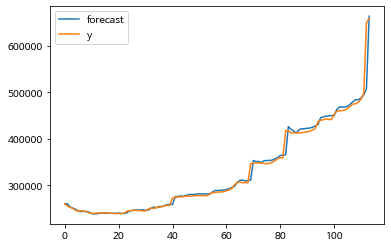

In [143]:
# 학습 데이터에 대한 예측 결과
fig = model_fit.plot_predict()

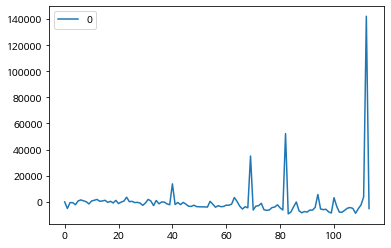

In [144]:
# 실제값과 예측값 사이의 오차 변동
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

In [155]:
forecast_data = model_fit.forecast(steps=10) 
forecast_data

(array([658588.4698578 , 657432.75959834, 647096.79684243, 653361.52647921,
        666402.2973689 , 679801.58008217, 693103.54530999, 703977.71688195,
        713436.02553675, 722897.91611922]),
 array([15084.84093525, 21555.72284895, 25952.31089371, 29184.46130388,
        31269.33901456, 33081.49477887, 34902.25360937, 36746.55334367,
        38609.41137549, 40412.49739928]),
 array([[629022.7249122 , 688154.2148034 ],
        [615184.31915367, 699681.20004302],
        [596231.20217517, 697962.39150968],
        [596161.0334154 , 710562.01954302],
        [605115.51908   , 727689.0756578 ],
        [614963.04176084, 744640.1184035 ],
        [624696.38525634, 761510.70536363],
        [631955.79577238, 775999.63799152],
        [637762.9697765 , 789109.081297  ],
        [643690.87669132, 802104.95554712]]))

In [156]:
# 마지막 5월의 예측 데이터
pred_y = forecast_data[0].tolist()

# 실제 5월의 데이터
test_y = test_df1.price.values

# 마지막 5월의 예측 데이터 최소값
pred_y_lower = []

# 마지막 5월의 예측 데이터 최대값
pred_y_upper = []

In [152]:
pred_y

[658588.4698577999,
 657432.7595983422,
 647096.7968424251,
 653361.5264792095,
 666402.2973688991]

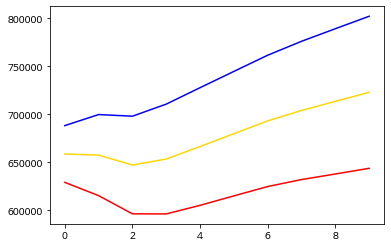

In [157]:
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

# 모델이 예측한 가격 그래프
plt.plot(pred_y, color = 'gold')

# 모델이 예측한 최저 가격 그래프
plt.plot(pred_y_lower, color = 'red')

# 모델이 예측한 최고 가격 그래프
plt.plot(pred_y_upper, color = 'blue')

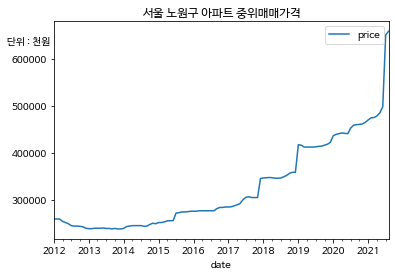

In [158]:
# 시각화
df1.plot()
plt.title('서울 노원구 아파트 중위매매가격')
plt.text(488,630000,'단위 : 천원')
plt.show()